In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import covid_funs
import importlib
import subprocess
import sys
import shlex

In [3]:
#from https://www.endpoint.com/blog/2015/01/28/getting-realtime-output-using-python
def run_command(command):
    process = subprocess.Popen(shlex.split(command), stdout=subprocess.PIPE, stderr = subprocess.STDOUT, text = False)
    outlist = []
    while True:
        output = process.stdout.readline()
        outlist += [output]
        if output.decode("utf-8") == '' and process.poll() is not None:
            break
        if output:
            if '\r' in output.decode("utf-8"):
                
                sys.stdout.write('\r' + output.decode("utf-8").strip())
            else:
                sys.stdout.write(output.decode("utf-8"))
    rc = process.poll()
    return rc,outlist

In [126]:
importlib.reload(covid_funs)

<module 'covid_funs' from '/Users/m197894/Documents/COVID_Model/disease_net/covid_funs.py'>

We can generate a simulated outbreak using the SIR model. We also give sampling bias and capacity. If capacity is given as a list, samples will be later generated for each capacity in the list. Capacity can also be given as a list (implying max capacities) and a function (which should take values from 0 to 1) for time-varying capacty. For this, pass the function as a keyword argument capacityfun to gen_jsons.

In [41]:
Bias = 1 #Bias = 1 means no bias. Higher puts bias towards testing symptomatic individuals.
capacities = [100,300,900,2700,8100]

def SIR_model(t,X,params):
    s,i,r= X
    beta,recrate = params
    if callable(beta):
        dsdt = -(beta(s,i,r,t))*s*i
    else:
        dsdt = -beta*s*i
    didt = -dsdt - recrate*i
    drdt = recrate*i
    return [dsdt,didt,drdt]

timescale = 15 #1/gamma


init_inf = 0.01

s0 = (1-init_inf)
i0 = init_inf
r0 = 0

R0 = 2.2

end_time = 100

dynamics = covid_funs.gen_jsons(end_time,[s0,i0,r0],SIR_model,1,-1,[0,2],[R0/timescale,1/timescale],Bias,capacities)

In [5]:
dynamics.keys()

dict_keys(['TimePoints', 'Symptomatic', 'Asymptomatic', 'NonInfected'])

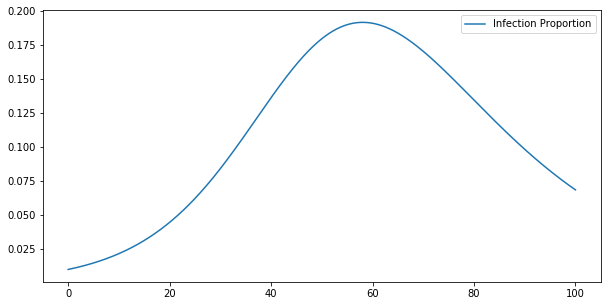

In [43]:
total_infected = np.array(dynamics['Symptomatic']) + np.array(dynamics['Asymptomatic'])

fig,ax = plt.subplots(figsize = (10,5))
ax.plot(dynamics["TimePoints"],total_infected, label = "Infection Proportion")

ax.legend()

We use a .go executible to generate simulated sampling.

In [44]:
%%time
svfl = "json_io/testresults.json"
dynamicsfl = "json_io/dynamics.json"
biasfl = "json_io/bias.json"
capfl = "json_io/capacity.json"
num_trials = 10
falsePos = 0.1
falseNeg = 0.1
smth = 5
peak_tol = 3

base_command = "./disease_confidence"
opts = ["-Dynamics="+dynamicsfl]
opts +=["-TestingBias="+biasfl]
opts +=["-TestingCapacities="+capfl]
opts +=["-Trials="+str(num_trials)]
opts +=["-SaveFile="+svfl]
opts +=["-FalsePositive="+str(falsePos)]
opts +=["-FalseNegative="+str(falseNeg)]
opts +=["-Smoothing="+str(smth)]
opts +=["-PeakTol="+str(peak_tol)]


full_command = base_command + " " + " ".join(opts)
so = run_command(full_command)

with open(svfl) as fl:
    results = json.load(fl)

Avg Tests Per Day: 900


Average sum-square error: 7268.223999999228


Avg Tests Per Day: 2700


Average sum-square error: 3247.0587499995786


Avg Tests Per Day: 8100


Average sum-square error: 807.0784999999174


Avg Tests Per Day: 100


Average sum-square error: 9889.142749999382


Avg Tests Per Day: 300


Average sum-square error: 7592.956999999013


CPU times: user 49 ms, sys: 19.9 ms, total: 68.9 ms
Wall time: 1min 4s


In [46]:
results.keys()

dict_keys(['Peaks', 'SumSqDistance', 'Performance'])

In [53]:
results["Performance"]["100"][0]["Sample"].keys()

dict_keys(['DailyPositive', 'DailyTotal', 'DayTimes'])

In [57]:
pos_prop = {}
for ky in results["Performance"]:
    smps = []
    for samp in results["Performance"][ky]:
        sample = samp["Sample"]
        smps += [(sample["DayTimes"],np.array(sample["DailyPositive"])/np.array(sample["DailyTotal"]))]
    pos_prop[ky] = smps

In [56]:
pos_prop.keys()

dict_keys(['100', '2700', '300', '8100', '900'])

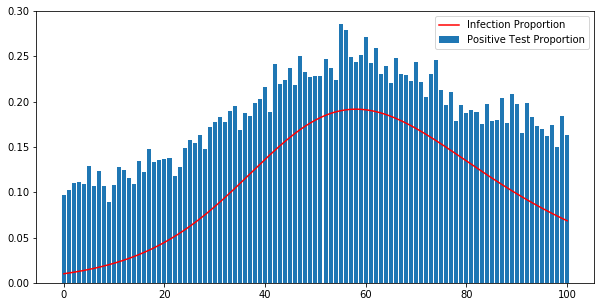

In [58]:

fig,ax = plt.subplots(figsize = (10,5))
ax.plot(dynamics["TimePoints"],total_infected, label = "Infection Proportion", color = 'red')
ax.bar(pos_prop["900"][0][0],pos_prop["900"][0][1], label = "Positive Test Proportion")

ax.legend()

In [182]:
performance = {}
for ky,val in samples.items():
    performance[ky]=[covid_funs.judge_peaks(covid_funs.findPeak_smth,dynamics,v,smoothing = 5) for v in val]

In [16]:
found_prob = {}
for ky,val in performance.items():
    found_prob[ky] = sum([pk["Found"] for dyn in val for  pk in dyn[0].values()])/sum([len(v[0]) for v in val])

In [17]:
false_pos = {}
for ky,val in performance.items():
    false_pos[ky] = 1-sum([pk["Real"] for dyn in val for  pk in dyn[1].values()])/sum([len(v[1]) for v in val])

In [18]:
found_prob

{'100': 0.6, '1000': 0.7, '2500': 0.6, '500': 0.8, '5000': 0.6}

In [19]:
false_pos

{'100': 0.9615384615384616,
 '1000': 0.925,
 '2500': 0.8552631578947368,
 '500': 0.9317073170731707,
 '5000': 0.864406779661017}

In [20]:
mean_sq_error = {}
for ky,val in performance.items():
    mean_sq_error[ky] =[(sum([pk["SqDist"] for pk in dyn[1].values()])/len(dyn[1]))**(1/2) for dyn in val]

In [21]:
mean_sq_error

{'100': [64.94749181876567,
  63.164773498456434,
  53.602158434983075,
  65.41100551785874,
  68.69025147827291,
  66.35444126055316,
  61.56137181707554,
  59.20453271117489,
  59.755790514394405,
  62.36565940462091],
 '1000': [72.08927528496427,
  84.03528316005024,
  83.61689014895349,
  83.44030712396446,
  88.7516963844157,
  76.65327600450287,
  82.05286764175654,
  83.2069151891505,
  83.75778254206583,
  90.2086213016431],
 '2500': [72.15090089527817,
  83.50613108372164,
  90.35197993280589,
  3.1666228067111675,
  87.21572392636739,
  97.80499366450961,
  57.34564063640875,
  78.7814742297865,
  103.55827724385334,
  81.617415420977],
 '500': [73.92418314017011,
  71.87134686368591,
  83.91281978058986,
  88.00754976585728,
  58.24361910687581,
  70.76123585693121,
  75.60633762770124,
  81.80180825222403,
  83.03743816113281,
  69.46076401894429],
 '5000': [92.0490222653147,
  89.01437885452853,
  76.19297321057186,
  76.30008191345712,
  64.14516739396797,
  90.4156414249

In [28]:
results["Performance"]["500"][0]["Precisions"]

[{'Peak': 19, 'Real': False, 'FoundOn': 21, 'SqDist': 37.04999999999702},
 {'Peak': 22, 'Real': False, 'FoundOn': 24, 'SqDist': 34.04999999999702},
 {'Peak': 30, 'Real': False, 'FoundOn': 31, 'SqDist': 27.04999999999702},
 {'Peak': 47, 'Real': False, 'FoundOn': 48, 'SqDist': 10.04999999999702},
 {'Peak': 48, 'Real': False, 'FoundOn': 51, 'SqDist': 7.04999999999702},
 {'Peak': 59, 'Real': True, 'FoundOn': 60, 'SqDist': -1.95000000000298},
 {'Peak': 60, 'Real': True, 'FoundOn': 61, 'SqDist': -2.95000000000298},
 {'Peak': 62, 'Real': False, 'FoundOn': 64, 'SqDist': -5.95000000000298},
 {'Peak': 61, 'Real': False, 'FoundOn': 65, 'SqDist': -6.95000000000298},
 {'Peak': 63, 'Real': False, 'FoundOn': 69, 'SqDist': -10.95000000000298},
 {'Peak': 100, 'Real': False, 'FoundOn': 104, 'SqDist': -45.95000000000298},
 {'Peak': 125, 'Real': False, 'FoundOn': 131, 'SqDist': -72.95000000000297},
 {'Peak': 148, 'Real': False, 'FoundOn': 150, 'SqDist': -91.95000000000297},
 {'Peak': 150, 'Real': False, '

In [35]:
found_prob = {}
for ky,val in results["Performance"].items():
    found_prob[ky] = sum([pk["Found"] for dyn in val for  pk in dyn["Recalls"]])/sum([len(v["Recalls"]) for v in val])
    
false_pos = {}
for ky,val in results["Performance"].items():
    false_pos[ky] = 1-sum([pk["Real"] for dyn in val for  pk in dyn["Precisions"]])/sum([len(v["Precisions"]) for v in val])
    
mean_sq_error = {}
for ky,val in results["Performance"].items():
    mean_sq_error[ky] =[(sum([(pk["SqDist"])**2 for pk in dyn["Precisions"]])/len(dyn["Precisions"]))**(1/2) for dyn in val]

In [36]:
found_prob

{'100': 0.6, '1000': 0.7, '2500': 0.8, '500': 0.7, '5000': 0.9}

In [37]:
false_pos

{'100': 0.9739413680781759,
 '1000': 0.9171974522292994,
 '2500': 0.8192771084337349,
 '500': 0.946078431372549,
 '5000': 0.7068965517241379}

In [38]:
mean_sq_error

{'100': [69.50745487920003,
  65.23183033756918,
  68.571878346741,
  67.97483624157701,
  67.63127358454008,
  66.13190172621793,
  69.6618573898245,
  64.83540524071294,
  58.16034367954907,
  83.44708145421362],
 '1000': [73.9146482591439,
  93.91342775005674,
  66.67861351288113,
  78.85145845195457,
  77.90674446627614,
  70.67344503654542,
  83.35742555247957,
  75.11616200337927,
  74.22643759781133,
  97.4796260764293],
 '2500': [79.5618155901454,
  99.40009770154842,
  83.4560458619351,
  76.49682999968218,
  56.25791055487354,
  78.44399807081244,
  82.57482970009893,
  83.23135259958171,
  70.45624528741406,
  88.04875070096342],
 '500': [77.66176742160788,
  68.91478433544006,
  82.07312128122342,
  72.06204870551909,
  68.35438903245519,
  75.93502156449458,
  74.96156237254955,
  86.99881268782507,
  85.56353127714956,
  69.44263656232752],
 '5000': [78.53390305194148,
  74.83706189672071,
  92.2599723607177,
  74.61134297142947,
  110.34447199565815,
  63.10009904905203,